Authors:
<br />
Arsh Lalani, Faculty of Engineering, Western University 
<br />
Andrew Harrop, Faculty of Engineering, Western University

External Libraries:

In [1]:
from sklearn.model_selection import train_test_split
import cv2
import numpy as np
import imutils
import matplotlib.pyplot as plt
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical


Internal Libraries:

In [2]:
# Internal libraries:
from load_images import load_images

from preprocessing import multiple_dataset_conversion
from preprocessing import crop_images
from preprocessing import preprocess_images
from preprocessing import augment_image_set

from plotting import plot_image_classes
from plotting import plot_cnn_history
from plotting import plot_image
from plotting import plot_augmented

# from Models.CNN import build_model
from Evaluation.evaluation import evalute_model
from preprocessing import labels_to_categorical


Load images from the dataset

In [3]:
dataset_1_tumor_images, dataset_1_normal_images = load_images(1)
dataset_2_tumor_images, dataset_2_normal_images = load_images(2)

Plot random images:

/Users/arshlalani/Desktop/Current Courses/AI 2/Advanced-AI-Thesis/plotting.py:63: MatplotlibDeprecationWarning: 
The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.
  fig.canvas.set_window_title("Image Labels")


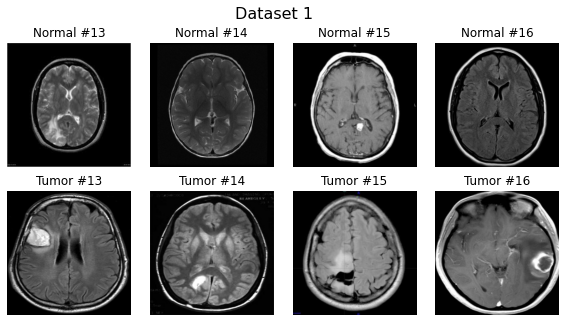

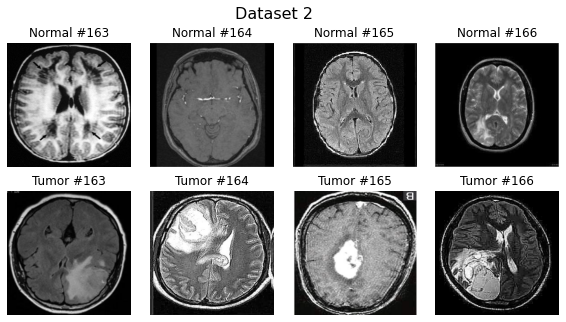

In [4]:
plot_image_classes(dataset_1_normal_images, dataset_1_tumor_images, n_images=4, title="Dataset 1")
plot_image_classes(dataset_2_normal_images, dataset_2_tumor_images, n_images=4, title="Dataset 2")

Crop the brain into the full view

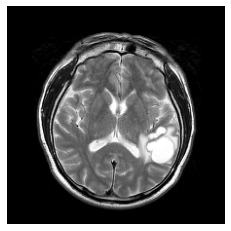

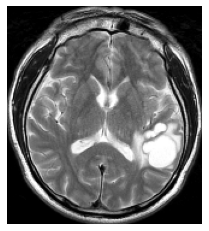

In [5]:
plot_image(dataset_1_tumor_images[4], save="uncropped_test")
dataset_1_tumor_images_proc = crop_images(dataset_1_tumor_images)
dataset_1_normal_images_proc = crop_images(dataset_1_normal_images)
dataset_2_tumor_images_proc = crop_images(dataset_2_tumor_images)
dataset_2_normal_images_proc = crop_images(dataset_2_normal_images)

test_image = dataset_1_tumor_images_proc[4]
plot_image(test_image, save="cropped_test")

In [6]:
dataset_1_normal_images_proc = preprocess_images(dataset_1_normal_images_proc, (224, 224))
dataset_1_tumor_images_proc = preprocess_images(dataset_1_tumor_images_proc, (224, 224))
dataset_2_normal_images_proc = preprocess_images(dataset_2_normal_images_proc, (224, 224))
dataset_2_tumor_images_proc = preprocess_images(dataset_2_tumor_images_proc, (224, 224))

Split the datasets. The light dataset contains many fewer images, which is convenient for testing preliminary models.

In [7]:
X, Y = multiple_dataset_conversion(yes = [dataset_1_normal_images_proc, dataset_2_normal_images_proc], no = [dataset_1_tumor_images_proc, dataset_2_tumor_images_proc])
X_light, Y_light = multiple_dataset_conversion(yes = [dataset_1_normal_images], no = [dataset_1_tumor_images])

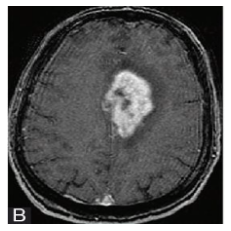

In [8]:
# Sp;it into train, test, and validation sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)
X_test, X_val, Y_test, Y_val = train_test_split(X_test, Y_test, test_size=0.5, random_state=42, stratify=Y_test)

X_light_train, X_light_test, Y_light_train, Y_light_test = train_test_split(X_light, Y_light, test_size=0.2, random_state=42, stratify=Y_light)
X_light_test, X_light_val, Y_light_test, Y_light_val = train_test_split(X_light_test, Y_light_test, test_size=0.5, random_state=42, stratify=Y_light_test)

plot_image(X_light_train[0], save="X_light_train")

Preform some data augmentation on the training data

In [9]:
example_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.08,
    height_shift_range=0.08,
    rescale=1./255,
    shear_range=0.1,
    brightness_range=[0.5, 1.5],
    horizontal_flip=True,
    vertical_flip=True
)


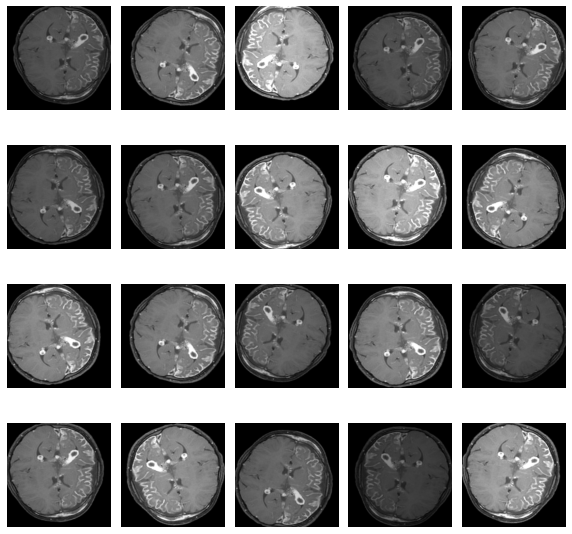

In [10]:
plot_augmented(X_light_train[5], example_datagen)

In [11]:
# Applting augmentation to the training set
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.08,
    height_shift_range=0.08,
    rescale=1./255,
    shear_range=0.1,
    brightness_range=[0.5, 1.5],
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)




        

In [12]:
X_train_augment, Y_train_augment = augment_image_set(X_train, Y_train, train_datagen)

In [13]:
X_test_augment, Y_test_augment = augment_image_set(X_test, Y_test, test_datagen)

In [14]:
X_val_augment, Y_val_augment = augment_image_set(X_val, Y_val, test_datagen)

In [15]:
X_train_light_augment, Y_train_light_augment = augment_image_set(X_light_train, Y_light_train, train_datagen)

In [16]:
X_test_light_augment, Y_test_light_augment = augment_image_set(X_light_test, Y_light_test, test_datagen)

In [17]:
X_val_light_augment, Y_val_light_augment = augment_image_set(X_light_val, Y_light_val, test_datagen)

Data is now ready to be used for training.

In [18]:
# def labels_to_categorical(labels):
#     label_binarizer = LabelBinarizer()
#     labels = label_binarizer .fit_transform(labels)
#     return to_categorical(labels)

Y_train_augment_cat = labels_to_categorical(Y_train_augment)
Y_test_augment_cat = labels_to_categorical(Y_test_augment)
Y_val_augment_cat = labels_to_categorical(Y_val_augment)

Y_train_light_augment_cat = labels_to_categorical(Y_train_light_augment)
Y_test_light_augment_cat = labels_to_categorical(Y_test_light_augment)
Y_val_light_augment_cat = labels_to_categorical(Y_val_light_augment)

In [19]:
from tensorflow.keras.models import Model
from tensorflow.keras import models
from tensorflow.keras.layers import Conv2D,Input,ZeroPadding2D,BatchNormalization,Flatten,Activation,Dense,MaxPooling2D


def build_model(input_shape):
    """
        Building a CNN model from scratch 
        
        :param input_shape: The shape of the input.
        :return: The CNN model
    """
    #Takes in raw pixel value of input images 
    model_input = Input(input_shape) 
    #This layer can add rows and columns of zeros at the top, bottom, left and right side of an image tensor
    model_output = ZeroPadding2D((2, 2))(model_input) 
    #This is a convolutional layer that takes in the model_output and applies a convolution filter to it to extract features from input image 
    model_output = Conv2D(filters = 32, kernel_size = (7, 7), strides = (1, 1))(model_output)
    #This is a normalization layer that applies a transformation that maintains the mean output close to 0 and the output standard deviation close to 1
    model_output = BatchNormalization(axis = 3)(model_output)
    #This is an activation layer that produces single output based on weighted sum of inputs
    model_output = Activation('relu')(model_output) 
    #This is a pooling layer that takes the max value over an input window (of size defined by pool_size) for each channel of the input
    model_output = MaxPooling2D(pool_size = (4, 4))(model_output) 
    model_output = MaxPooling2D(pool_size = (4, 4))(model_output) 
    #This is a layer that flattens the input matrix into vectors and does not affect the batch size 
    model_output = Flatten()(model_output) 
    #This is a dense layer that takes in the model_output and runs fully connected neural network layer on it to produce single output
    #We used sigmod activation function for this layer to get outputs in 1 or 0 classifyin brain tumor or not
    model_output = Dense(units = 2, activation='sigmoid')(model_output) 

    model = Model(inputs = model_input, outputs = model_output)
    
    return model

In [20]:

model = build_model((224, 224, 3))
model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 228, 228, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 222, 222, 32)      4736      
_________________________________________________________________
batch_normalization (BatchNo (None, 222, 222, 32)      128       
_________________________________________________________________
activation (Activation)      (None, 222, 222, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 55, 55, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 32)        0     

2022-04-07 15:38:04.235030: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [51]:
# Using Adam optimizer, Cross entropy loss function, and accuracy as metrics
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Fit model 
history = model.fit(x=X_train_light_augment, y=Y_train_light_augment_cat, batch_size=32, epochs=10, validation_data=(X_val_light_augment, Y_val_light_augment_cat), steps_per_epoch=None,workers = 1)

Epoch 1/10
26/26 [==============================] - 61s 2s/step - loss: 0.4463 - accuracy: 0.7673 - val_loss: 0.6213 - val_accuracy: 0.7692
Epoch 2/10
26/26 [==============================] - 67s 3s/step - loss: 0.4214 - accuracy: 0.7871 - val_loss: 1.0085 - val_accuracy: 0.7981
Epoch 3/10
26/26 [==============================] - 71s 3s/step - loss: 0.4078 - accuracy: 0.7809 - val_loss: 0.6467 - val_accuracy: 0.8077
Epoch 4/10
26/26 [==============================] - 67s 3s/step - loss: 0.4024 - accuracy: 0.7995 - val_loss: 0.7673 - val_accuracy: 0.7885
Epoch 5/10
26/26 [==============================] - 58s 2s/step - loss: 0.4023 - accuracy: 0.7995 - val_loss: 0.7934 - val_accuracy: 0.7788
Epoch 6/10
26/26 [==============================] - 60s 2s/step - loss: 0.3895 - accuracy: 0.8057 - val_loss: 0.7709 - val_accuracy: 0.7788
Epoch 7/10
26/26 [==============================] - 63s 2s/step - loss: 0.3938 - accuracy: 0.8069 - val_loss: 0.8219 - val_accuracy: 0.7788
Epoch 8/10
26/26 [==

In [52]:
result = evalute_model(model,X_test_light_augment,Y_test_light_augment_cat, 32)

Actuals: [1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 0 0 0 0 1 1 1 1 0 0 0 0 1 1 1 1]
Predictions: [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 1 1 1 1 0 0 0 0 1 0 0 0 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 1 1 1 1]
[[58  2]
 [12 28]]
              precision    recall  f1-score   support

          no       0.83      0.97      0.89        60
         yes       0.93      0.70      0.80        40

    accuracy                           0.86       100
   macro avg       0.88      0.83      0.85       100
weighted avg       0.87      0.86      0.86       100

Accuracy: 0.860000


In [63]:
# Save the tensorflow model 
model.save('./Save_model/cnn_model.h5')

/Users/arshlalani/miniconda3/envs/tensorflow-env/lib/python3.9/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [46]:
from tensorflow.keras.applications.resnet50 import ResNet50 
from tensorflow.keras import Model, layers
from tensorflow.keras.optimizers import SGD

conv_base = ResNet50(
    include_top=False,
    weights='imagenet')

for layer in conv_base.layers:
    layer.trainable = False
    
x = conv_base.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x) 
predictions = layers.Dense(2, activation='softmax')(x)
new_model = Model(conv_base.input, predictions)
new_model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='binary_crossentropy', metrics=['accuracy'])

/Users/arshlalani/miniconda3/envs/tensorflow-env/lib/python3.9/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [47]:
new_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = new_model.fit(x=X_train_light_augment, y=Y_train_light_augment_cat, batch_size=32, epochs=4, validation_data=(X_val_light_augment, Y_val_light_augment_cat), steps_per_epoch=None,workers =4)


Epoch 1/4
26/26 [==============================] - 62s 2s/step - loss: 0.6985 - accuracy: 0.6510 - val_loss: 0.5261 - val_accuracy: 0.8750
Epoch 2/4
26/26 [==============================] - 57s 2s/step - loss: 0.5303 - accuracy: 0.7463 - val_loss: 0.5470 - val_accuracy: 0.8269
Epoch 3/4
26/26 [==============================] - 57s 2s/step - loss: 0.4917 - accuracy: 0.7599 - val_loss: 0.6348 - val_accuracy: 0.6346
Epoch 4/4
26/26 [==============================] - 60s 2s/step - loss: 0.5365 - accuracy: 0.7030 - val_loss: 0.5552 - val_accuracy: 0.7981


In [61]:
result = evalute_model(new_model,X_test_light_augment,Y_test_light_augment_cat, 32)

Actuals: [1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 0 0 0 0 1 1 1 1 0 0 0 0 1 1 1 1]
Predictions: [1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 1 1 1 0 1 1 1 0 0 0 0 1 1 1 1 0 0 0 0 1 1 1 1]
[[42 18]
 [ 5 35]]
              precision    recall  f1-score   support

          no       0.89      0.70      0.79        60
         yes       0.66      0.88      0.75        40

    accuracy                           0.77       100
   macro avg       0.78      0.79      0.77       100
weighted avg       0.80      0.77      0.77       100

Accuracy: 0.770000


In [49]:
new_model.save('./Save_model/reznet50_model.h5')

/Users/arshlalani/miniconda3/envs/tensorflow-env/lib/python3.9/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [57]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import RMSprop


def build_cnn() -> Model:
    """
        Build a CNN model.
        :return: The CNN model.
    
    """

    base_VGG16_model = VGG16(weights="./Save_model/pretrained_vgg.h5", include_top=False, input_shape=(224, 224, 3))

    
    

    model = Sequential()
    model.add(base_VGG16_model)
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='sigmoid'))

    model.layers[0].trainable = False

    model.compile(loss='binary_crossentropy', optimizer=RMSprop(lr=1e-4), metrics=['accuracy'])

    return model

In [58]:
model_vgg = build_cnn()
model_vgg.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dropout (Dropout)            (None, 25088)             0         
_________________________________________________________________
dense_7 (Dense)              (None, 2)                 50178     
Total params: 14,764,866
Trainable params: 50,178
Non-trainable params: 14,714,688
_________________________________________________________________


/Users/arshlalani/miniconda3/envs/tensorflow-env/lib/python3.9/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [60]:
history = model_vgg.fit(x=X_train_light_augment, y=Y_train_light_augment_cat, batch_size=32, epochs=4, validation_data=(X_val_light_augment, Y_val_light_augment_cat), steps_per_epoch=None,workers =1)

Epoch 1/4
26/26 [==============================] - 139s 5s/step - loss: 1.7017 - accuracy: 0.6324 - val_loss: 3.6267 - val_accuracy: 0.6731
Epoch 2/4
26/26 [==============================] - 134s 5s/step - loss: 1.2957 - accuracy: 0.7153 - val_loss: 4.5515 - val_accuracy: 0.6731
Epoch 3/4
26/26 [==============================] - 128s 5s/step - loss: 1.0990 - accuracy: 0.7537 - val_loss: 3.1307 - val_accuracy: 0.7692
Epoch 4/4
26/26 [==============================] - 131s 5s/step - loss: 1.0019 - accuracy: 0.7710 - val_loss: 3.1620 - val_accuracy: 0.7788


In [62]:
result = evalute_model(model_vgg,X_test_light_augment,Y_test_light_augment_cat, 32)

Actuals: [1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 0 0 0 0 1 1 1 1 0 0 0 0 1 1 1 1]
Predictions: [1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 1 0 0 0 1
 0 0 0 1 1 1 1 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 1 0 0 0]
[[56  4]
 [21 19]]
              precision    recall  f1-score   support

          no       0.73      0.93      0.82        60
         yes       0.83      0.47      0.60        40

    accuracy                           0.75       100
   macro avg       0.78      0.70      0.71       100
weighted avg       0.77      0.75      0.73       100

Accuracy: 0.750000


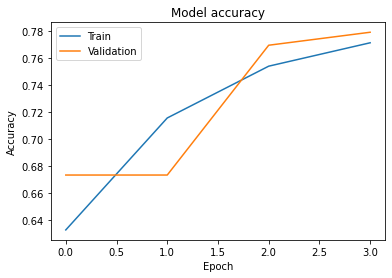

In [64]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()